##  SimplePendulum.ipynb
- Notebook dedicado a probar modelos kan el problema lagrangiano del Péndulo Simple
- Se recurre a
    - mini_kan: Framework usado para construir modelos KAN
    - lagrangian_kan: Framework dedicado a la construccion de problemas lagrangianos

In [1]:
# Se importan librerias fundamentales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import os
import sys
from copy import deepcopy

In [2]:
# Se importa funcionalidades de torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


In [3]:
# Se importa todas las utilidades de mini_kan
sys.path.append('/home/colmanok/Code/mini_kan')

from mini_kan import KAN, KANLayer
from mini_kan.basis import LegendreBasis, MonomialBasis, get_basis
from mini_kan.layer import KANLayer
from mini_kan.visualization import *

In [4]:
# Se importan funcionalidades de lagrangian_kan
sys.path.append('/home/colmanok/Code/lagrangian_kan')

from lagrangian_kan import (
    SimplePendulum,
    EulerLagrangeSolver,
    TrajectoryIntegrator,
    LagrangianTrainer,
    compute_lagrangian_error,
    compute_acceleration_error,
)

In [5]:
# Configurar matplotlib para mostrar gráficas dentro del notebook
%matplotlib inline

In [6]:
# ============================================================================
# EXPERIMENTO: Oscilador Armónico - Aprendizaje de Lagrangiano
# ============================================================================

# Configuración del experimento
torch.manual_seed(42)
np.random.seed(42)

print("=" * 70)
print("EXPERIMENTO: Oscilador Armónico - Aprendizaje de Lagrangiano")
print("=" * 70)
print("\nObjetivo: Aprender L(q, q̇) usando lagrangian_kan")
print("Lagrangiano verdadero: L = m * q̇²/2 - k * q²/2")
print("Comparación: MLP vs KAN")
print("=" * 70)

EXPERIMENTO: Oscilador Armónico - Aprendizaje de Lagrangiano

Objetivo: Aprender L(q, q̇) usando lagrangian_kan
Lagrangiano verdadero: L = m * q̇²/2 - k * q²/2
Comparación: MLP vs KAN


In [7]:
# 1. CREAR SISTEMA FÍSICO Y GENERAR DATOS
# ============================================================================

# Crear sistema físico: péndulo simple 1D
system = SimplePendulum(m=1.0, l=1.0, g=9.81)
print(f"\nSistema creado: {system}")
print(f"  - Grados de libertad: {system.n_dof}")
print(f"  - Masa: {system.m.item():.2f}")
print(f"  - Longitud: {system.l.item():.2f}")
print(f"  - Frecuencia natural (pequeñas oscilaciones): ω₀ = {system.omega0.item():.4f}")

# Generar datos de entrenamiento
print("\nGenerando datos de entrenamiento...")
train_data = system.generate_trajectories(
    n_trajectories=100,
    n_points_per_traj=50,
    t_max=10.0,
    seed=42
)

# Generar datos de test
print("Generando datos de test...")
test_data = system.generate_trajectories(
    n_trajectories=20,
    n_points_per_traj=50,
    t_max=10.0,
    seed=123
)

# Resumen de los datos generados
print(f"\nDatos generados:")
print(f"  Train: q={train_data['q'].shape}, qdot={train_data['qdot'].shape}, "
      f"qddot={train_data['qddot'].shape}, L={train_data['L'].shape}")
print(f"  Test:  q={test_data['q'].shape}, qdot={test_data['qdot'].shape}, "
      f"qddot={test_data['qddot'].shape}, L={test_data['L'].shape}")

print(f"\n  Rango q: [{train_data['q'].min():.3f}, {train_data['q'].max():.3f}]")
print(f"  Rango q̇: [{train_data['qdot'].min():.3f}, {train_data['qdot'].max():.3f}]")


Sistema creado: SimplePendulum(n_dof=1, name='SimplePendulum')
  - Grados de libertad: 1
  - Masa: 1.00
  - Longitud: 1.00
  - Frecuencia natural (pequeñas oscilaciones): ω₀ = 3.1321

Generando datos de entrenamiento...
Generando datos de test...

Datos generados:
  Train: q=torch.Size([5000, 1]), qdot=torch.Size([5000, 1]), qddot=torch.Size([5000, 1]), L=torch.Size([5000, 1])
  Test:  q=torch.Size([1000, 1]), qdot=torch.Size([1000, 1]), qddot=torch.Size([1000, 1]), L=torch.Size([1000, 1])

  Rango q: [-1.563, 1.563]
  Rango q̇: [-4.405, 4.410]


In [8]:
# 2. CREAR MODELOS: PyTorch MLP y KAN
# ============================================================================

class SimpleMLP(nn.Module):
    """MLP simple para modelar L(q, q̇)."""
    def __init__(self, in_dim=2, hidden_dim=10, out_dim=1):
        super().__init__()
        self.layer1 = nn.Linear(in_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, out_dim)
        self.activation = nn.SiLU()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)
        return x

# Crear modelo PyTorch MLP
torch_model = SimpleMLP(in_dim=2, hidden_dim=10, out_dim=1)
print("\nModelo PyTorch MLP creado:")
print(torch_model)
print(f"Parámetros: {sum(p.numel() for p in torch_model.parameters())}")

# Crear modelo KAN
basis_monomial = MonomialBasis(order=2)
basis_legendre = LegendreBasis(order=2)

kan_layers = [
    KANLayer(
        in_dim=2, 
        out_dim=5, 
        basis=basis_monomial, 
        #basis=basis_legendre,
        bias=True
    ),
    KANLayer(
        in_dim=5, 
        out_dim=1, 
        basis=basis_monomial, 
        #basis=basis_legendre,
        bias=True
    ),
]

kan_model = KAN(layers=kan_layers)
print("\nModelo KAN creado:")
print(kan_model)
print(f"Parámetros: {sum(p.numel() for p in kan_model.parameters())}")


Modelo PyTorch MLP creado:
SimpleMLP(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (activation): SiLU()
)
Parámetros: 151

Modelo KAN creado:
KAN(
  layers=2, preprocessor=None
  (layers): ModuleList(
    (0): KANLayer(
      in_dim=2, out_dim=5, basis=MonomialBasis(dim=3), bias=True, activation=None, params=35
      (basis): MonomialBasis()
    )
    (1): KANLayer(
      in_dim=5, out_dim=1, basis=MonomialBasis(dim=3), bias=True, activation=None, params=16
      (basis): MonomialBasis()
    )
  )
)
Parámetros: 51


In [9]:
# 3. ENTRENAR MODELOS
# ============================================================================

print("\n" + "=" * 70)
print("ENTRENAMIENTO")
print("=" * 70)

# Configuración de entrenamiento
num_epochs = 1000
lr = 0.001 * 10

# Entrenar modelo MLP
print("\n[1/2] Entrenando modelo MLP...")
trainer_mlp = LagrangianTrainer()
history_mlp = trainer_mlp.train(
    model=torch_model,
    train_data=train_data,
    num_epochs=num_epochs,
    lr=lr,
    print_every=200,
    # Regularizadores opcionales
    acceleration_weight=0.0,  # Desactivado
    mass_weight=0.1,          # Activar regularizador de masa
    interaction_weight=0.0,   # Desactivado
)

# Entrenar modelo KAN
print("\n[2/2] Entrenando modelo KAN...")
trainer_kan = LagrangianTrainer()
history_kan = trainer_kan.train(
    model=kan_model,
    train_data=train_data,
    num_epochs=num_epochs,
    lr=lr,
    print_every=200,
    # Regularizadores opcionales
    #acceleration_weight=0.01,  # Desactivado
    mass_weight=0.1,          # Activar regularizador de masa
    interaction_weight=0.0,   # Desactivado
)

print("\nEntrenamiento completado")


ENTRENAMIENTO

[1/2] Entrenando modelo MLP...
Epoch 1/1000 | Loss: 0.002306 | Main: 0.001097 | mass: 0.001209
Epoch 200/1000 | Loss: 0.000002 | Main: 0.000002 | mass: 0.000000
Epoch 400/1000 | Loss: 0.000001 | Main: 0.000001 | mass: 0.000000
Epoch 600/1000 | Loss: 0.000000 | Main: 0.000000 | mass: 0.000000
Epoch 800/1000 | Loss: 0.000000 | Main: 0.000000 | mass: 0.000000
Epoch 1000/1000 | Loss: 0.000000 | Main: 0.000000 | mass: 0.000000

[2/2] Entrenando modelo KAN...
Epoch 1/1000 | Loss: 0.394457 | Main: 0.386765 | mass: 0.007691
Epoch 200/1000 | Loss: 0.000001 | Main: 0.000001 | mass: 0.000000
Epoch 400/1000 | Loss: 0.000000 | Main: 0.000000 | mass: 0.000000
Epoch 600/1000 | Loss: 0.000000 | Main: 0.000000 | mass: 0.000000
Epoch 800/1000 | Loss: 0.000000 | Main: 0.000000 | mass: 0.000000
Epoch 1000/1000 | Loss: 0.000000 | Main: 0.000000 | mass: 0.000000

Entrenamiento completado


In [10]:
# 4. EVALUAR MODELOS
# ============================================================================

print("\n" + "=" * 70)
print("EVALUACIÓN EN TEST SET")
print("=" * 70)

# Evaluar MLP
print("\n[1/2] Evaluando modelo MLP...")
metrics_mlp = trainer_mlp.evaluate(torch_model, test_data)

# Evaluar KAN
print("[2/2] Evaluando modelo KAN...")
metrics_kan = trainer_kan.evaluate(kan_model, test_data)

# Mostrar comparación
print("\n" + "-" * 70)
print(f"{'Métrica':<25} {'MLP':<15} {'KAN':<15} {'Diferencia':<15}")
print("-" * 70)
for key in sorted(set(metrics_mlp.keys()) | set(metrics_kan.keys())):
    val_mlp = metrics_mlp.get(key, 0.0)
    val_kan = metrics_kan.get(key, 0.0)
    diff = abs(val_mlp - val_kan)
    print(f"{key:<25} {val_mlp:<15.6f} {val_kan:<15.6f} {diff:<15.6f}")
print("=" * 70)


EVALUACIÓN EN TEST SET

[1/2] Evaluando modelo MLP...
[2/2] Evaluando modelo KAN...

----------------------------------------------------------------------
Métrica                   MLP             KAN             Diferencia     
----------------------------------------------------------------------
L_MSE                     11.226809       11.240775       0.013967       
qddot_MAE                 0.031254        0.018508        0.012746       
qddot_MSE                 0.001517        0.000516        0.001001       



VISUALIZACIONES


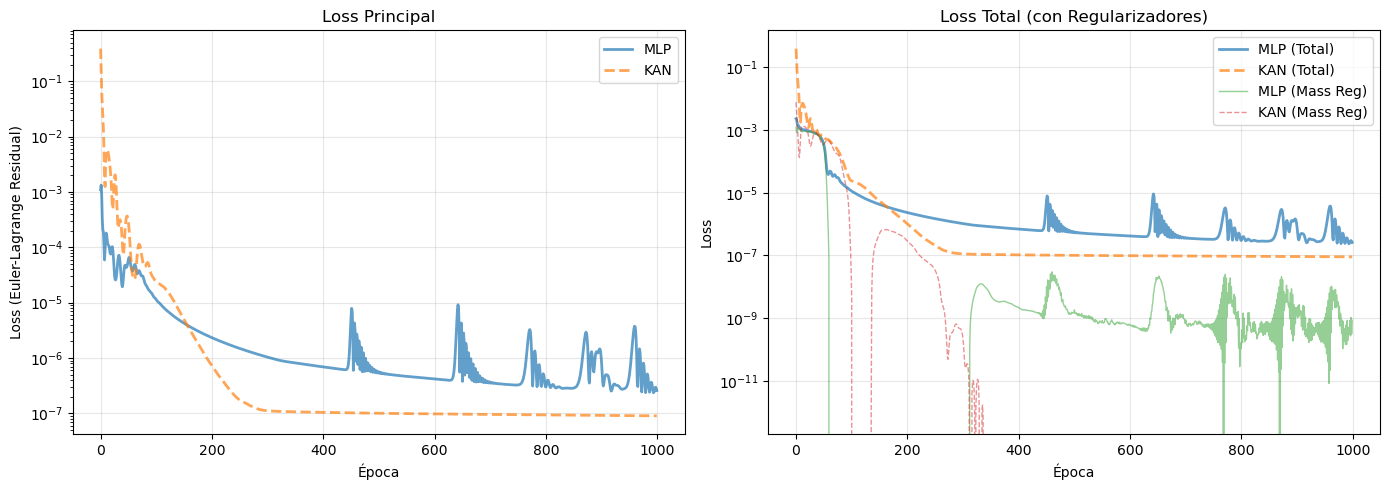


Gráficos de pérdida generados


In [11]:
# 6. VISUALIZACIONES
# ============================================================================

print("\n" + "=" * 70)
print("VISUALIZACIONES")
print("=" * 70)

# 6.1 Curvas de pérdida
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss principal
ax1 = axes[0]
ax1.plot(history_mlp['main_loss'], label='MLP', alpha=0.7, linewidth=2)
ax1.plot(history_kan['main_loss'], label='KAN', alpha=0.7, linewidth=2, linestyle='--')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss (Euler-Lagrange Residual)')
ax1.set_title('Loss Principal')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Loss total (con regularizadores)
ax2 = axes[1]
ax2.plot(history_mlp['loss'], label='MLP (Total)', alpha=0.7, linewidth=2)
ax2.plot(history_kan['loss'], label='KAN (Total)', alpha=0.7, linewidth=2, linestyle='--')
if 'reg_mass' in history_mlp:
    ax2.plot(history_mlp['reg_mass'], label='MLP (Mass Reg)', alpha=0.5, linewidth=1)
if 'reg_mass' in history_kan:
    ax2.plot(history_kan['reg_mass'], label='KAN (Mass Reg)', alpha=0.5, linewidth=1, linestyle='--')
ax2.set_xlabel('Época')
ax2.set_ylabel('Loss')
ax2.set_title('Loss Total (con Regularizadores)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print("\nGráficos de pérdida generados")

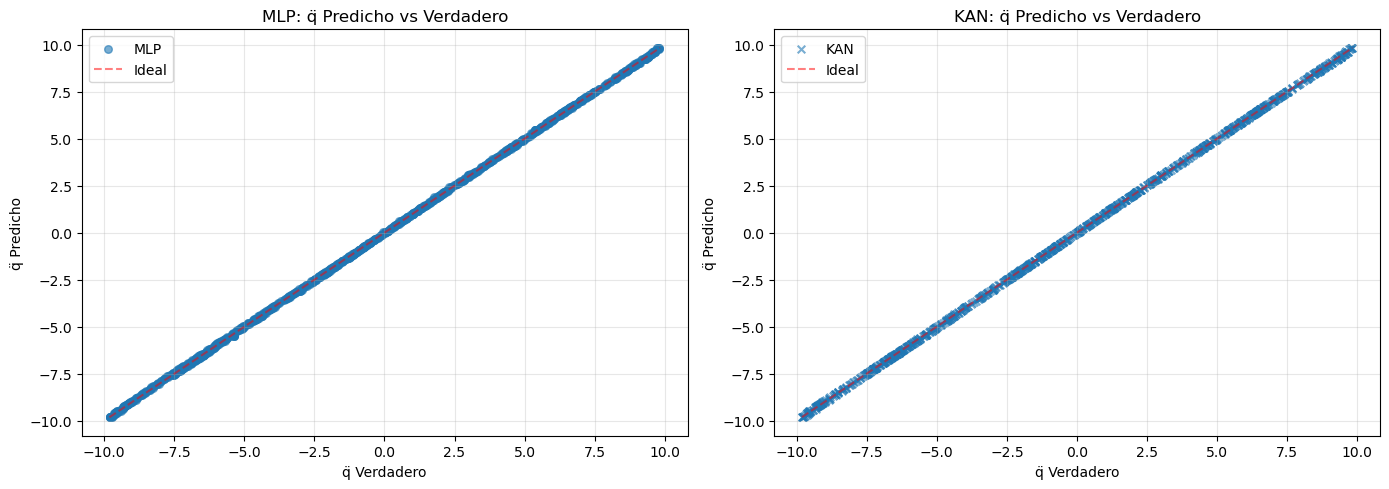


Gráficos de predicciones generados


In [12]:
# 6.2 Comparación de predicciones: q̈ predicho vs q̈ verdadero
from lagrangian_kan.lagrangian import EulerLagrangeSolver

solver = EulerLagrangeSolver()

# Calcular q̈ predicho para ambos modelos
torch_model.eval()
kan_model.eval()

with torch.no_grad():
    qddot_pred_mlp = solver.compute_acceleration(
        torch_model, 
        test_data['q'], 
        test_data['qdot']
    )
    qddot_pred_kan = solver.compute_acceleration(
        kan_model, 
        test_data['q'], 
        test_data['qdot']
    )

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MLP
ax1 = axes[0]
qddot_true_np = test_data['qddot'].detach().cpu().numpy()
qddot_pred_mlp_np = qddot_pred_mlp.detach().cpu().numpy()
ax1.scatter(qddot_true_np, qddot_pred_mlp_np, alpha=0.6, s=30, label='MLP')
min_val = min(qddot_true_np.min(), qddot_pred_mlp_np.min())
max_val = max(qddot_true_np.max(), qddot_pred_mlp_np.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Ideal')
ax1.set_xlabel('q̈ Verdadero')
ax1.set_ylabel('q̈ Predicho')
ax1.set_title('MLP: q̈ Predicho vs Verdadero')
ax1.legend()
ax1.grid(True, alpha=0.3)

# KAN
ax2 = axes[1]
qddot_pred_kan_np = qddot_pred_kan.detach().cpu().numpy()
ax2.scatter(qddot_true_np, qddot_pred_kan_np, alpha=0.6, s=30, label='KAN', marker='x')
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Ideal')
ax2.set_xlabel('q̈ Verdadero')
ax2.set_ylabel('q̈ Predicho')
ax2.set_title('KAN: q̈ Predicho vs Verdadero')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGráficos de predicciones generados")


Integrando trayectorias usando los Lagrangianos aprendidos...


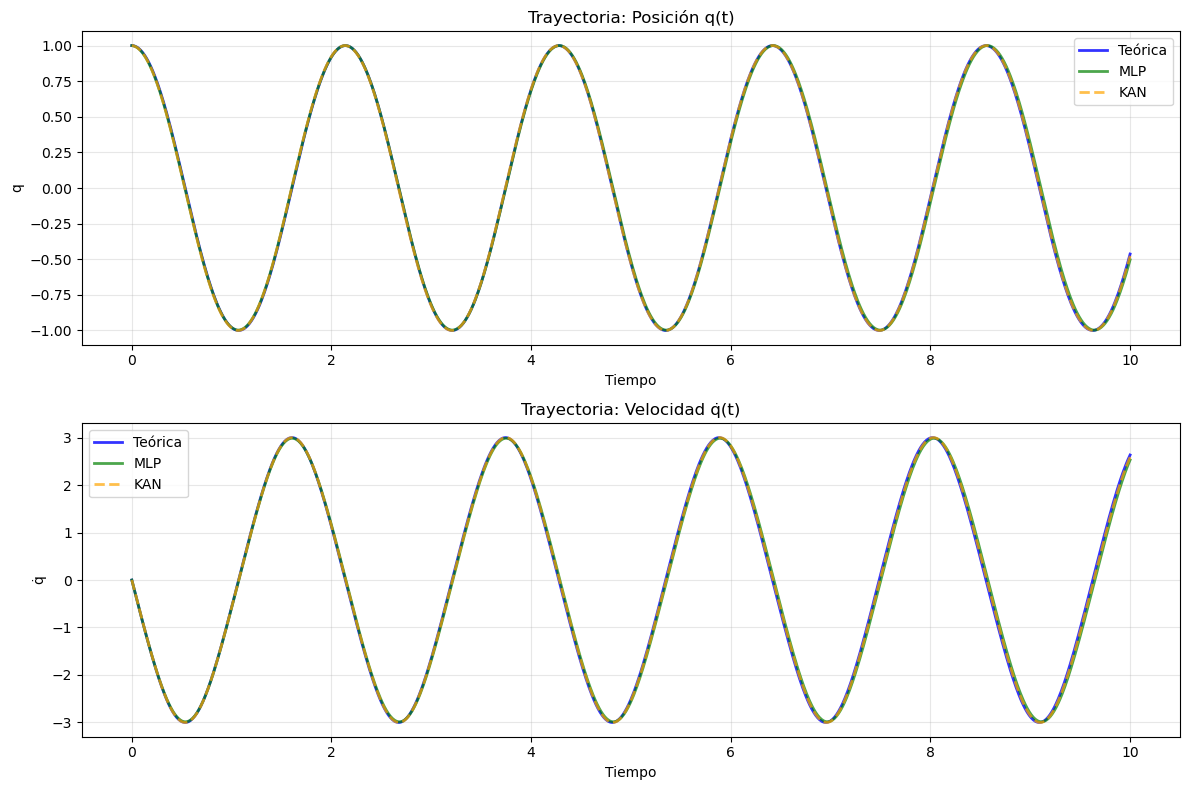


Trayectorias integradas y visualizadas


In [13]:
# 6.3 Integrar trayectorias usando los modelos aprendidos
print("\nIntegrando trayectorias usando los Lagrangianos aprendidos...")

integrator = TrajectoryIntegrator()

# Condiciones iniciales
q_init = torch.tensor([[1.0]])
qdot_init = torch.tensor([[0.0]])
t_span = 10.0

# Integrar con MLP
q_traj_mlp, qdot_traj_mlp = integrator.integrate(
    model=torch_model,
    q_init=q_init,
    qdot_init=qdot_init,
    t_span=t_span,
    dt=0.01,
        method='variational'
)

# Integrar con KAN
q_traj_kan, qdot_traj_kan = integrator.integrate(
    model=kan_model,
    q_init=q_init,
    qdot_init=qdot_init,
    t_span=t_span,
    dt=0.01,
        method='variational'
)

# Trayectoria teórica (integración numérica)
from scipy.integrate import odeint
omega0 = system.omega0.item()
g = system.g.item()
l = system.l.item()

def pendulum_ode_theory(y, t):
    theta, theta_dot = y
    omega0_sq = g / l
    theta_ddot = -omega0_sq * np.sin(theta)
    return [theta_dot, theta_ddot]

t_theory = np.linspace(0, t_span, len(q_traj_mlp))
theta0 = q_init[0, 0].item()
theta_dot0 = qdot_init[0, 0].item()
y0 = [theta0, theta_dot0]
sol_theory = odeint(pendulum_ode_theory, y0, t_theory)
q_theory = sol_theory[:, 0]
qdot_theory = sol_theory[:, 1]

# Visualizar trayectorias
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Posición q
ax1 = axes[0]
ax1.plot(t_theory, q_theory, 'b-', label='Teórica', linewidth=2, alpha=0.8)
ax1.plot(t_theory, q_traj_mlp.detach().cpu().numpy(), 'g-', label='MLP', linewidth=2, alpha=0.7)
ax1.plot(t_theory, q_traj_kan.detach().cpu().numpy(), 'orange', label='KAN', linewidth=2, alpha=0.7, linestyle='--')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('q')
ax1.set_title('Trayectoria: Posición q(t)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Velocidad q̇
ax2 = axes[1]
ax2.plot(t_theory, qdot_theory, 'b-', label='Teórica', linewidth=2, alpha=0.8)
ax2.plot(t_theory, qdot_traj_mlp.detach().cpu().numpy(), 'g-', label='MLP', linewidth=2, alpha=0.7)
ax2.plot(t_theory, qdot_traj_kan.detach().cpu().numpy(), 'orange', label='KAN', linewidth=2, alpha=0.7, linestyle='--')
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('q̇')
ax2.set_title('Trayectoria: Velocidad q̇(t)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTrayectorias integradas y visualizadas")


Graficando diagrama de fases (q vs q̇) para diferentes condiciones iniciales...

[1/4] Condición inicial: q=0.50, q̇=0.00

[2/4] Condición inicial: q=1.00, q̇=-0.50

[3/4] Condición inicial: q=-1.50, q̇=1.50

[4/4] Condición inicial: q=2.00, q̇=-2.00


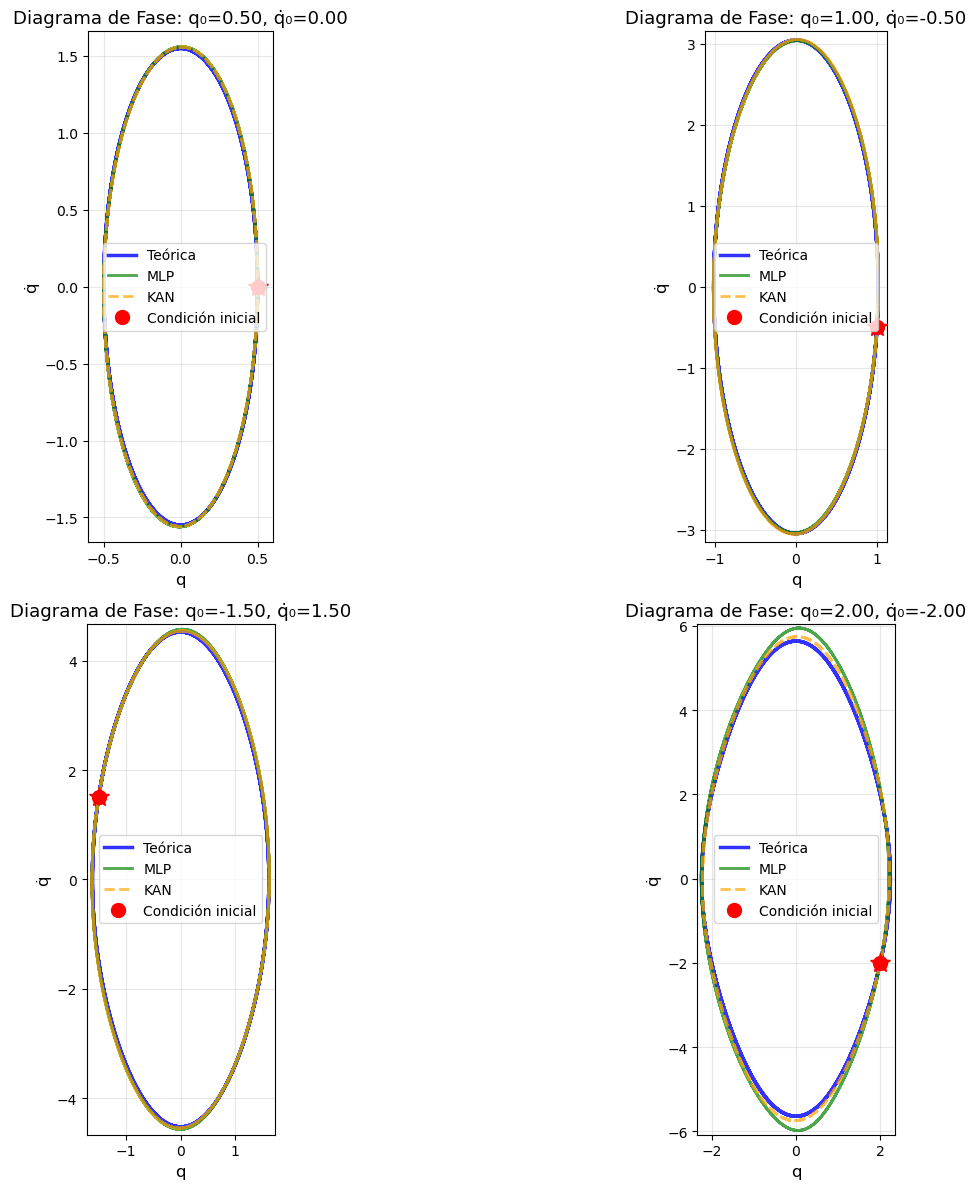


Diagramas de fase (q vs q̇) generados


In [14]:
# 6.4 Graficar diagrama de fases para diferentes condiciones iniciales (q vs q̇)
print("\nGraficando diagrama de fases (q vs q̇) para diferentes condiciones iniciales...")

# Condiciones iniciales
q_init_list = [0.5, 1.0, -1.5, 2.0]
qdot_init_list = [0.0, -0.5, 1.5, -2.0]

# Configuración de integración
t_span = 10.0
dt = 0.01

# Crear integrador
integrator = TrajectoryIntegrator()

# Preparar modelos para evaluación
torch_model.eval()
kan_model.eval()

# Crear figura con subplots (2x2 para 4 condiciones iniciales)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (q_init_val, qdot_init_val) in enumerate(zip(q_init_list, qdot_init_list)):
    print(f"\n[{idx+1}/4] Condición inicial: q={q_init_val:.2f}, q̇={qdot_init_val:.2f}")

    # Convertir a tensores 2D ([1,1]) para integración (acorde a la API de integrator)
    q_init = torch.tensor([[q_init_val]], dtype=torch.float32)  # [1, 1]
    qdot_init = torch.tensor([[qdot_init_val]], dtype=torch.float32)  # [1, 1]

    # Integrar trayectorias con los modelos (output: [n_steps+1, 1])
    q_traj_mlp, qdot_traj_mlp = integrator.integrate(
        model=torch_model,
        q_init=q_init,
        qdot_init=qdot_init,
        t_span=t_span,
        dt=dt,
        method='variational'
    )
    q_traj_kan, qdot_traj_kan = integrator.integrate(
        model=kan_model,
        q_init=q_init,
        qdot_init=qdot_init,
        t_span=t_span,
        dt=dt,
        method='variational'
    )

    # Trayectoria teórica (integración numérica)
    from scipy.integrate import odeint
    g_val = system.g.item()
    l_val = system.l.item()

    def pendulum_ode_theory(y, t):
        theta, theta_dot = y
        omega0_sq = g_val / l_val
        theta_ddot = -omega0_sq * np.sin(theta)
        return [theta_dot, theta_ddot]

    t_theory = np.linspace(0, t_span, len(q_traj_mlp))
    y0 = [q_init_val, qdot_init_val]
    sol_theory = odeint(pendulum_ode_theory, y0, t_theory)
    q_theory = sol_theory[:, 0]
    qdot_theory = sol_theory[:, 1]

    # Convertir a numpy para visualización
    q_traj_mlp_np = q_traj_mlp.detach().cpu().numpy().flatten()
    qdot_traj_mlp_np = qdot_traj_mlp.detach().cpu().numpy().flatten()
    q_traj_kan_np = q_traj_kan.detach().cpu().numpy().flatten()
    qdot_traj_kan_np = qdot_traj_kan.detach().cpu().numpy().flatten()

    # Graficar diagrama de fase q vs qdot
    ax = axes[idx]

    # Teórico
    ax.plot(q_theory, qdot_theory, 'b-', label='Teórica', linewidth=2.5, alpha=0.8)
    # MLP y KAN
    ax.plot(q_traj_mlp_np, qdot_traj_mlp_np, 'g-', label='MLP', linewidth=2, alpha=0.7)
    ax.plot(q_traj_kan_np, qdot_traj_kan_np, 'orange', label='KAN', linewidth=2, alpha=0.7, linestyle='--')

    # Marcar condición inicial
    ax.plot(q_init_val, qdot_init_val, 'ro', markersize=10, label='Condición inicial', zorder=5)
    ax.plot(q_init_val, qdot_init_val, 'r*', markersize=15, zorder=5)

    ax.set_xlabel('q', fontsize=12)
    ax.set_ylabel('q̇', fontsize=12)
    ax.set_title(f'Diagrama de Fase: q₀={q_init_val:.2f}, q̇₀={qdot_init_val:.2f}', fontsize=13)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

    # Ajustar límites para mejor visualización
    all_q = np.concatenate([q_theory, q_traj_mlp_np, q_traj_kan_np])
    all_qdot = np.concatenate([qdot_theory, qdot_traj_mlp_np, qdot_traj_kan_np])
    margin = 0.1
    q_range = [all_q.min() - margin, all_q.max() + margin]
    qdot_range = [all_qdot.min() - margin, all_qdot.max() + margin]
    ax.set_xlim(q_range)
    ax.set_ylim(qdot_range)

plt.tight_layout()
plt.show()

print("\nDiagramas de fase (q vs q̇) generados")


Graficando diagrama de fases para diferentes condiciones iniciales (KAN vs teórica)...

[1/4] Condición inicial: q=0.50, q̇=0.00

[2/4] Condición inicial: q=1.00, q̇=-0.50

[3/4] Condición inicial: q=-1.50, q̇=1.50

[4/4] Condición inicial: q=2.00, q̇=-2.00


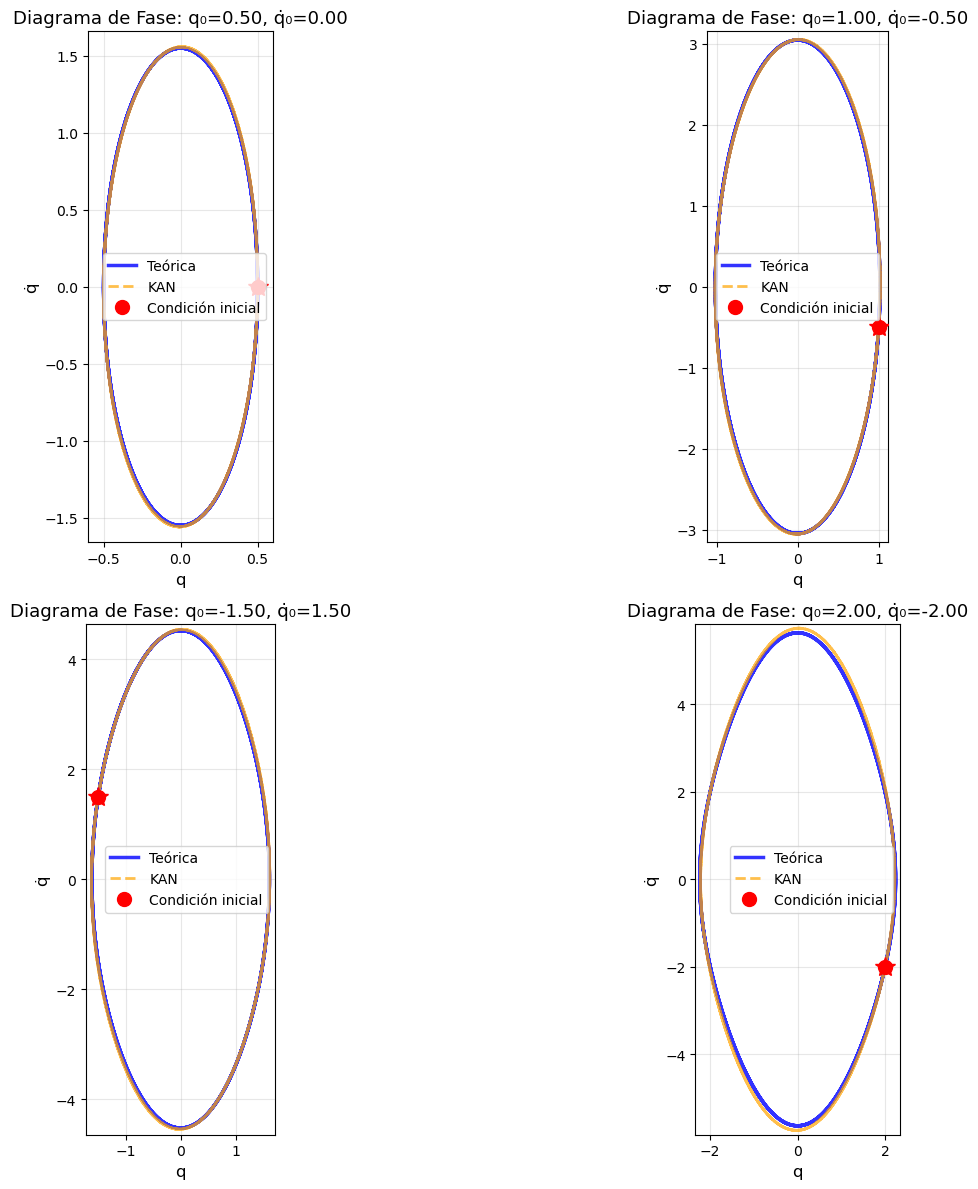


Diagramas de fase generados (solo comparación KAN vs teórica)


In [15]:
# 6.4.5 Graficar diagrama de fases para diferentes condiciones iniciales (solo comparación KAN vs teórica)
print("\nGraficando diagrama de fases para diferentes condiciones iniciales (KAN vs teórica)...")

# Condiciones iniciales
q_init_list = [0.5, 1.0, -1.5, 2.0]        # q_init = [q0], todos dentro de [-2.5, 2.5]
qdot_init_list = [0.0, -0.5, 1.5, -2.0]    # qdot_init = [qdot0], todos dentro de [-2.5, 2.5]

# Configuración de integración
t_span = 10.0
dt = 0.01

# Crear integrador
integrator = TrajectoryIntegrator()

# Preparar modelo KAN para evaluación
kan_model.eval()

# Crear figura con subplots (2x2 para 4 condiciones iniciales)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Para cada condición inicial
for idx, (q_init_val, qdot_init_val) in enumerate(zip(q_init_list, qdot_init_list)):
    print(f"\n[{idx+1}/4] Condición inicial: q={q_init_val:.2f}, q̇={qdot_init_val:.2f}")
    
    # Convertir a tensores
    q_init = torch.tensor([[q_init_val]], dtype=torch.float32)
    qdot_init = torch.tensor([[qdot_init_val]], dtype=torch.float32)
    
    # Integrar trayectorias con el modelo KAN
    q_traj_kan, qdot_traj_kan = integrator.integrate(
        model=kan_model,
        q_init=q_init,
        qdot_init=qdot_init,
        t_span=t_span,
        dt=dt,
        method='variational'
    )
    
    # Trayectoria teórica (integración numérica)
    from scipy.integrate import odeint
    omega0_val = system.omega0.item()
    g_val = system.g.item()
    l_val = system.l.item()
    
    def pendulum_ode_theory(y, t):
        theta, theta_dot = y
        omega0_sq = g_val / l_val
        theta_ddot = -omega0_sq * np.sin(theta)
        return [theta_dot, theta_ddot]
    
    t_theory = np.linspace(0, t_span, len(q_traj_kan))
    y0 = [q_init_val, qdot_init_val]
    sol_theory = odeint(pendulum_ode_theory, y0, t_theory)
    q_theory = sol_theory[:, 0]
    qdot_theory = sol_theory[:, 1]
    
    # Convertir a numpy para visualización
    q_traj_kan_np = q_traj_kan.detach().cpu().numpy().flatten()
    qdot_traj_kan_np = qdot_traj_kan.detach().cpu().numpy().flatten()
    
    # Graficar diagrama de fase
    ax = axes[idx]
    
    # Trayectoria teórica (curva cerrada)
    ax.plot(q_theory, qdot_theory, 'b-', label='Teórica', linewidth=2.5, alpha=0.8)
    
    # Trayectoria del modelo KAN
    ax.plot(q_traj_kan_np, qdot_traj_kan_np, 'orange', label='KAN', linewidth=2, alpha=0.7, linestyle='--')
    
    # Marcar condición inicial
    ax.plot(q_init_val, qdot_init_val, 'ro', markersize=10, label='Condición inicial', zorder=5)
    ax.plot(q_init_val, qdot_init_val, 'r*', markersize=15, zorder=5)
    
    # Configurar gráfico
    ax.set_xlabel('q', fontsize=12)
    ax.set_ylabel('q̇', fontsize=12)
    ax.set_title(f'Diagrama de Fase: q₀={q_init_val:.2f}, q̇₀={qdot_init_val:.2f}', fontsize=13)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    # Ajustar límites para mejor visualización
    all_q = np.concatenate([q_theory, q_traj_kan_np])
    all_qdot = np.concatenate([qdot_theory, qdot_traj_kan_np])
    margin = 0.1
    q_range = [all_q.min() - margin, all_q.max() + margin]
    qdot_range = [all_qdot.min() - margin, all_qdot.max() + margin]
    ax.set_xlim(q_range)
    ax.set_ylim(qdot_range)

plt.tight_layout()
plt.show()

print("\nDiagramas de fase generados (solo comparación KAN vs teórica)")

In [16]:
# 7. RESUMEN Y CONCLUSIONES
# ============================================================================

print("\n" + "=" * 70)
print("RESUMEN Y CONCLUSIONES")
print("=" * 70)

print("\nExperimentos completados:")
print(f"  1. Sistema físico: {system.name} (n_dof={system.n_dof})")
print(f"  2. Modelos entrenados: MLP ({sum(p.numel() for p in torch_model.parameters())} params) vs KAN ({sum(p.numel() for p in kan_model.parameters())} params)")
print(f"  3. Loss principal: Euler-Lagrange Residual")
print(f"  4. Regularizadores: Mass (weight=0.1)")

print("\nResultados principales:")
print(f"  - MLP - Loss final: {history_mlp['main_loss'][-1]:.6f}")
print(f"  - KAN - Loss final: {history_kan['main_loss'][-1]:.6f}")
if 'L_MSE' in metrics_mlp:
    print(f"  - MLP - Error en L: {metrics_mlp['L_MSE']:.6f}")
    print(f"  - KAN - Error en L: {metrics_kan['L_MSE']:.6f}")
if 'qddot_MSE' in metrics_mlp:
    print(f"  - MLP - Error en q̈: {metrics_mlp['qddot_MSE']:.6f}")
    print(f"  - KAN - Error en q̈: {metrics_kan['qddot_MSE']:.6f}")

print("\n" + "=" * 70)


RESUMEN Y CONCLUSIONES

Experimentos completados:
  1. Sistema físico: SimplePendulum (n_dof=1)
  2. Modelos entrenados: MLP (151 params) vs KAN (51 params)
  3. Loss principal: Euler-Lagrange Residual
  4. Regularizadores: Mass (weight=0.1)

Resultados principales:
  - MLP - Loss final: 0.000000
  - KAN - Loss final: 0.000000
  - MLP - Error en L: 11.226809
  - KAN - Error en L: 11.240775
  - MLP - Error en q̈: 0.001517
  - KAN - Error en q̈: 0.000516

